In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from ml_model import PipelineManager

In [47]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False

## Data setup

In [48]:
df_notas = pd.read_csv('../data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('../data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('../data/sociodemografico.csv', sep=';')

In [49]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [50]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [51]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [52]:
df_notas = df_notas.dropna()
df_notas['IDRecord'] = df_notas['IDRecord'].astype(str)
df_notas = df_notas[df_notas.IDRecord.str.isnumeric()]
df_notas['IDRecord'] = df_notas['IDRecord'].astype(int)

In [53]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINÚA EN PROGRAMA DE CRÓNICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...


## Hyperparameter Setup

In [54]:
numerical_features = ['Edad']
categorical_features=['Genero', 'GrupoEtnico', 'AreaResidencial', 'EstadoCivil', 'TSangre', 'Tipo']
text_features='Plan'

target_feature = 'Código'

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_features(text_features)
pipeline.set_basic_pipeline()

param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
    "bootstrap": [True, False],
}
estimator = RandomForestClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
    "eta":  np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 100, dtype=float),
    "reg_alpha": np.linspace(0, 10, 100, dtype=float),
    "scale_pos_weight": np.linspace(0.1, 1.5, 5, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
}
estimator = PassiveAggressiveClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
}
estimator = SGDClassifier()
pipeline.add_estimator(estimator, param_grid)

pipeline.pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('...
                                                                   CountVectorizer(stop_words=['de',
                                                                                               'la',
                                                                                               'que',
                                                                                               'el',
                                                                                               'en',
                                                                                               'y',
                                                                                               'a',
                                                                                               'los',
                                                                                               'del',
                                                                                               'se',
                                                                                               'las',
                                                                                               'por',
                                                                                               'un',
                                                                                               'para',
                                                                                               'con',
                                                                                               'no',
                                                                                               'una',
                                                                                               'su',
                                                                                               'al',
                                                                                               'lo',
                                                                                               'como',
                                                                                               'más',
                                                                                               'pero',
                                                                                               'sus',
                                                                                               'le',
                                                                                               'ya',
                                                                                               'o',
                                                                                               'este',
     

## Label encoding

In [55]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

y_labels

array([1, 1, 1, ..., 1, 1, 1])

## Train-test split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)

## Hyperparameter tuning

In [57]:
scoring = {"Accuracy": "balanced_accuracy", "Weighted_F1": make_scorer(f1_score, average='weighted')}
best_model = pipeline.find_best_model(X_train, y_train, cv=5, n_iter=30, n_jobs=-3, scoring=scoring, refit='Weighted_F1')

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn

In [58]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('sca...
                               eval_metric=None, gamma=0.0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.5,
                               max_bin=256, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=10, max_leaves=0,
                               min_child_weight=0.5, missing=nan,
                               monotone_constraints='()', n_estimators=78,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=4.040404040404041, ...))])

In [59]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,param_estimator__subsample,...,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,split2_test_Weighted_F1,split3_test_Weighted_F1,split4_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
29,66.990688,2.569362,1.768889,0.168574,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(norm='l1'),StandardScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),1.0,...,0.006994,1,0.931062,0.921151,0.927179,0.924922,0.925228,0.925908,0.003233,1
23,39.141640,1.845896,2.683469,0.360251,"CountVectorizer(ngram_range=(2, 2),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),SimpleImputer(strategy='median'),SelectFromModel(estimator=ElasticNet()),1.0,...,0.003855,2,0.917164,0.910236,0.910672,0.913306,0.911861,0.912648,0.002497,2
15,24.463017,1.665368,1.967770,0.060425,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),MinMaxScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.325,...,0.003459,4,0.912881,0.907789,0.910378,0.910526,0.907976,0.909910,0.001880,3
13,26.709712,1.478789,2.931825,0.416247,"CountVectorizer(ngram_range=(1, 2),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",StandardScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.775,...,0.003309,5,0.907558,0.905291,0.905005,0.905286,0.908198,0.906268,0.001334,4
0,28.983548,0.593652,2.274074,0.058360,"CountVectorizer(ngram_range=(2, 2),\n ...",TfidfTransformer(),MinMaxScaler(),KNNImputer(),SelectFromModel(estimator=ElasticNet()),0.325,...,0.003243,3,0.904126,0.903377,0.902144,0.904021,0.905465,0.903827,0.001081,5
12,26.078636,3.041730,2.261623,0.262465,"CountVectorizer(ngram_range=(2, 2),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),1.0,...,0.004681,6,0.903001,0.894686,0.899833,0.899523,0.898565,0.899121,0.002672,6
2,24.661047,0.551882,2.033104,0.457565,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),StandardScaler(),SimpleImputer(),SelectFromModel(estimator=Ridge()),0.775,...,0.003206,7,0.900849,0.898923,0.898287,0.896712,0.896941,0.898342,0.001500,7
28,46.536748,1.560499,2.538779,0.306680,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),RobustScaler(),KNNImputer(),SelectFromModel(estimator=ElasticNet()),1.0,...,0.003908,9,0.890523,0.886105,0.888965,0.884747,0.884824,0.887033,0.002319,8
14,20.854422,1.339121,2.233368,0.537760,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),1.0,...,0.007326,8,0.887810,0.888927,0.886299,0.881024,0.890373,0.886886,0.003221,9
10,38.768391,0.348201,3.948854,1.168886,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=ElasticNet()),0.325,...,0.013147,11,0.886584,0.867999,0.884240,0.883040,0.883956,0.881164,0.006686,10


## Scoring

In [60]:
score = pipeline.score(X_test, y_test)
score

,ROC_AUC,accuracy,balanced_accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,confusion_matrix_normalized,classification_report
0,NA,0.932636,0.874354,0.932636,0.886583,0.931503,"[[87984, 2897], [4654, 16557]]","[[0.7849266673803661, 0.025844841737144488], [...",precision recall f1-score ...


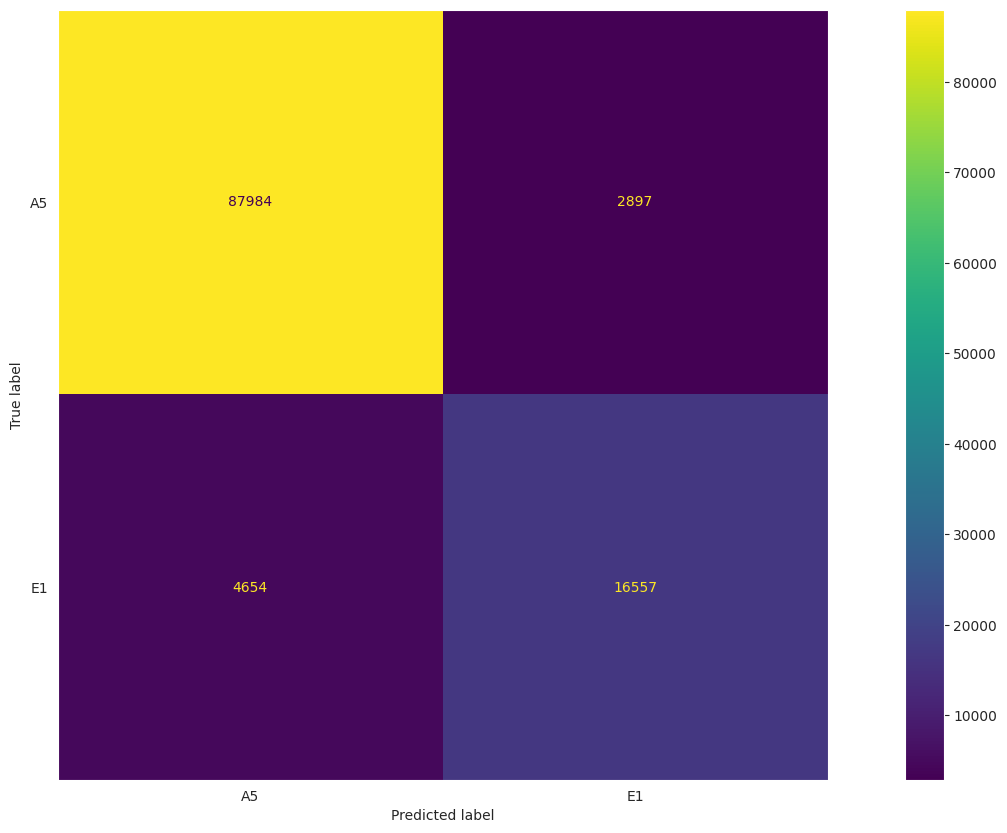

In [61]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=score.loc[0,'confusion_matrix'],
                                display_labels=labels_decoded)
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

In [62]:
score.loc[0,'classification_report'].round(2).rename(index={str(class_label):label for class_label, label in zip(best_model['estimator'].classes_, labels_decoded)})

,precision,recall,f1-score,support
A5,0.95,0.97,0.96,90881.00
E1,0.85,0.78,0.81,21211.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.90,0.87,0.89,112092.00
weighted avg,0.93,0.93,0.93,112092.00
